In [97]:
import pickle
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from alphatoe.interpretability import numpy
from alphatoe import plot, game, evals, interpretability
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [98]:
n_epochs = 1000
epochs = [x for x in range(n_epochs) if x % 10 == 0 or x == n_epochs - 1]

chkpts = [interpretability.load_model(
    f"../scripts/models/prob all 8 layer control with checkpoints-20250708-002411-epoch{x}"
) for x in epochs]

model = interpretability.load_model(
    "../scripts/models/prob all 8 layer control with checkpoints-20250708-002411"
)

chkpts = [(x, y) for x, y in zip(epochs, chkpts)]

In [99]:
# First, let's extract the data for all epochs
def get_projection_data(model, seq_fwd, just_proj=True):
    """Extract W_Q and compute projection for a given model checkpoint"""
    pos_emb = model.pos_embed(seq_fwd, 0)[0]  # positional embedding (10, 128)
    W_K = model.W_K[0, 1]  # Head index 1 (128, 16)
    
    # Compute SVD
    U, S, V = np.linalg.svd(numpy(W_K))
    
    # Project positional embeddings onto first singular vector
    Q_proj = numpy(pos_emb) @ U[:, :1]
    
    # Convert to list of values
    Q_proj = Q_proj.flatten().tolist()
    
    if just_proj:
        return Q_proj
    else:
        return {
            'u1': U[:, 0],
            'posemd': numpy(pos_emb),
        }

In [100]:
# Prepare sequence
seq_fwd = torch.tensor([[10, 0, 1, 2, 3, 4, 5, 7, 8, 6]])

# Get projections for all checkpoints
all_projections = []
for epoch, checkpoint in chkpts:
    proj = get_projection_data(checkpoint, seq_fwd)
    all_projections.append((epoch, proj))

# Also get projection for final model
final_proj = get_projection_data(model, seq_fwd)
all_projections.append((n_epochs, final_proj))

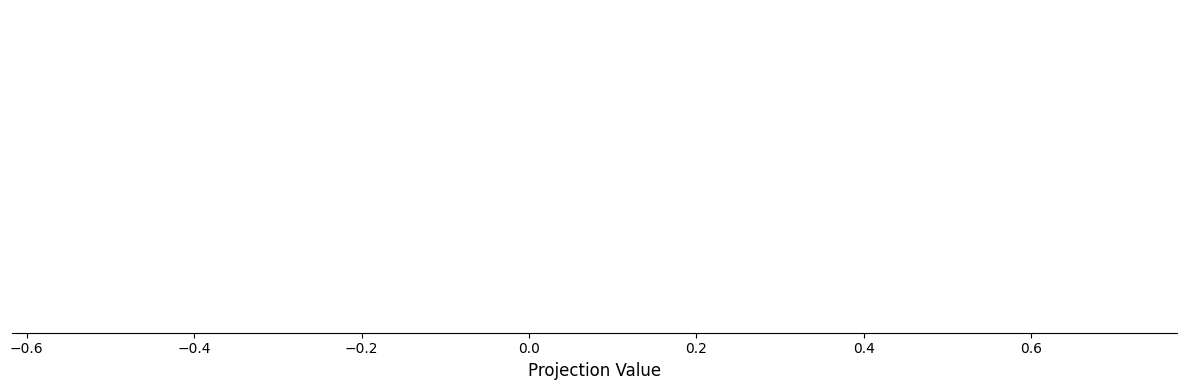

In [101]:
# Create the animation
fig, ax = plt.subplots(figsize=(12, 4))

# Set up the plot limits based on all data
all_values = [val for _, proj in all_projections for val in proj]
x_margin = 0.1 * (max(all_values) - min(all_values))
ax.set_xlim(min(all_values) - x_margin, max(all_values) + x_margin)
ax.set_ylim(-20, 20)

# Remove y-axis and spines
ax.yaxis.set_visible(False)
for spine in ['left', 'top', 'right']:
    ax.spines[spine].set_visible(False)

# Set labels
ax.set_xlabel('Projection Value', fontsize=12)

# Initialize plot elements
line, = ax.plot([], [], 'b-', linewidth=2)
points, = ax.plot([], [], 'bo', markersize=10)
annotations = []
epoch_text = ax.text(0.02, 0.98, '', transform=ax.transAxes, 
                     fontsize=14, fontweight='bold', va='top')

def init():
    """Initialize animation"""
    line.set_data([], [])
    points.set_data([], [])
    for ann in annotations:
        ann.remove()
    annotations.clear()
    epoch_text.set_text('')
    return line, points, epoch_text

def animate(frame):
    """Update animation for each frame"""
    epoch, proj_values = all_projections[frame]
    
    # Create position-value pairs
    positions = list(range(10))
    
    # Update line and points
    line.set_data(proj_values, [0]*len(proj_values))
    points.set_data(proj_values, [0]*len(proj_values))
    
    # Clear previous annotations
    for ann in annotations:
        ann.remove()
    annotations.clear()
    
    # Add new annotations
    for i, (pos, val) in enumerate(zip(positions, proj_values)):
        if i % 2 == 0:
            y_pos = 10
            va = 'bottom'
        else:
            y_pos = -10
            va = 'top'
        
        ann = ax.annotate(f'Pos {pos}', (val, 0), 
                         xytext=(0, y_pos), 
                         textcoords='offset points',
                         ha='center', va=va,
                         rotation=45, 
                         rotation_mode='anchor',
                         fontsize=10)
        annotations.append(ann)
    
    # Update epoch text
    epoch_text.set_text(f'Epoch: {epoch}')
    
    # Update title
    ax.set_title('Projection of Positional Embeddings onto First Singular Vector of W_Q', 
                 fontsize=14, pad=20)
    
    return line, points, epoch_text, *annotations

# Create animation
anim = FuncAnimation(fig, animate, init_func=init, 
                    frames=len(all_projections), 
                    interval=200,  # 200ms between frames
                    repeat=True,
                    blit=False)

# Show the animation
plt.tight_layout()
plt.show()

# Save the animation as a GIF
anim.save('projection_animation.gif', writer='pillow', fps=5)

In [80]:
# Prepare sequence
seq_fwd = torch.tensor([[10, 0, 1, 2, 3, 4, 5, 7, 8, 6]])

# Get projections for all checkpoints
all_pos_u = []
for epoch, checkpoint in chkpts:
    data = get_projection_data(checkpoint, seq_fwd, just_proj=False)
    all_pos_u.append((epoch, data))

In [81]:
lastu = all_pos_u[-1][1]['u1']
last_pos = all_pos_u[-1][1]['posemd']
last_proj = last_pos @ lastu

u_260 = all_pos_u[26][1]['u1']
pos_260 = all_pos_u[26][1]['posemd']
proj_260 = pos_260 @ u_260

u_270 = all_pos_u[27][1]['u1']
pos_270 = all_pos_u[27][1]['posemd']
proj_270 = pos_270 @ u_270

print(f"last projection: {last_proj}")

print(f"260 projection: {proj_260}")

print(f"270 projection: {proj_270}")


last projection: [-0.07889619 -0.087083    0.13034472  0.01557245  0.0191633  -0.5708306
  0.6313445  -0.68366796  0.6505547  -0.07979   ]
260 projection: [ 0.0184544  -0.03369582 -0.08302311 -0.00365206 -0.14208144 -0.13534068
 -0.17518364 -0.14759563 -0.67467356 -0.07416997]
270 projection: [-2.0729084e-02  3.4755290e-02  8.2116097e-02 -6.5048155e-04
  1.3646241e-01  1.2787876e-01  1.6323589e-01  1.1635549e-01
  6.8428558e-01  7.0673920e-02]


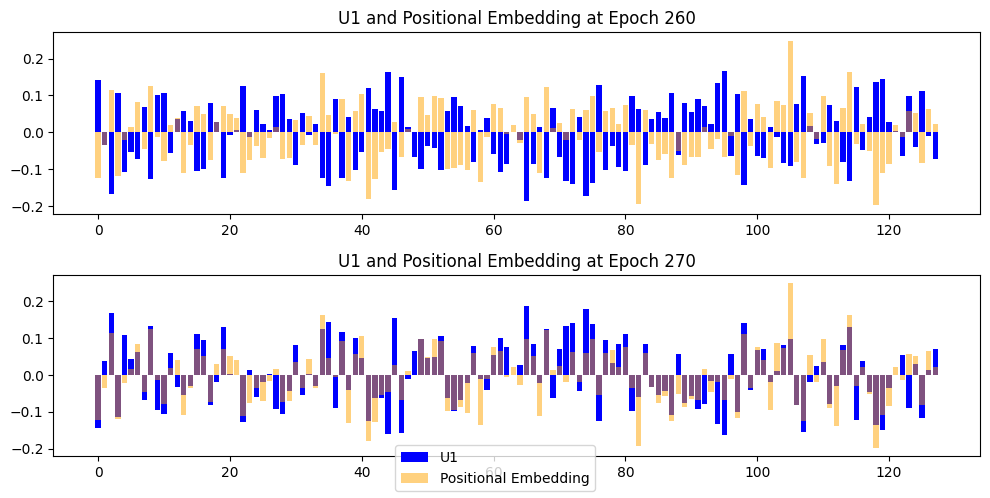

In [82]:
#bar plot U[:, :1]
fig, axes = plt.subplots(2, 1, figsize=(10, 5))
axes[0].bar(range(128), u_260, color='blue')
#add bar plot for pos_emb
axes[0].bar(range(128), pos_260[8], color='orange', alpha=0.5)
#title
axes[0].set_title('U1 and Positional Embedding at Epoch 260')
#legend
fig.legend(['U1', 'Positional Embedding'], loc='lower center')

axes[1].bar(range(128), u_270, color='blue')
axes[1].bar(range(128), pos_270[8], color='orange', alpha=0.5)
axes[1].set_title('U1 and Positional Embedding at Epoch 270')

#tight
plt.tight_layout()

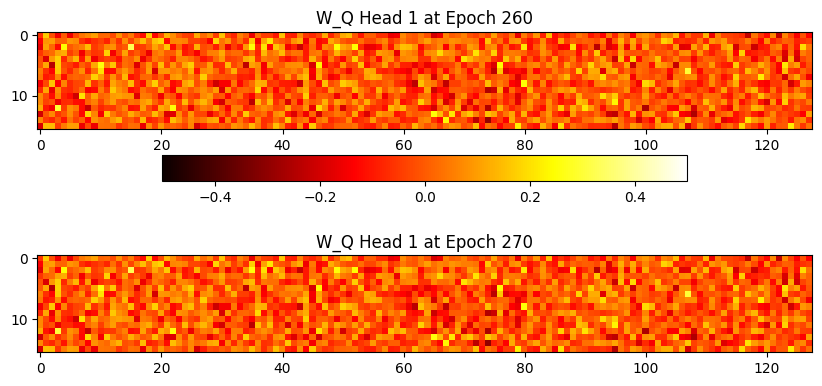

In [85]:
W_Q_260 = chkpts[26][1].W_Q[0, 1]
W_Q_270 = chkpts[27][1].W_Q[0, 1]


fig, ax = plt.subplots(2,1, figsize=(10,5))
ax[0].imshow(numpy(W_Q_260.T), cmap="hot", vmin=-0.5, vmax=0.5);
ax[0].set_title('W_Q Head 1 at Epoch 260')
im = ax[1].imshow(numpy(W_Q_270.T), cmap="hot", vmin=-0.5, vmax=0.5);
ax[1].set_title('W_Q Head 1 at Epoch 270')
#colorbar
fig.colorbar(im, ax=ax[0], orientation='horizontal');

In [95]:
#linalg of W_Q_260 and W_Q_270
U_260, S_260, V_260 = np.linalg.svd(numpy(W_Q_260))
U_270, S_270, V_270 = np.linalg.svd(numpy(W_Q_270))

U1_260 = U_260[:, 0]
U1_270 = U_270[:, 0]

U2_260 = U_260[:, 1]
U2_270 = U_270[:, 1]

#frobenius norm normalized of U1_260 and U1_270 difference
fro_sim = 1 - np.linalg.norm(numpy(W_Q_260) - numpy(W_Q_270), 'fro') / (np.linalg.norm(numpy(W_Q_260), 'fro') + np.linalg.norm(numpy(W_Q_270), 'fro'))

#dot product of U1_260 and U1_270
dot_product = np.dot(U1_260, U1_270)
print(f"Dot product of U1 at epochs 260 and 270: {dot_product}")
print(f"Frobenius norm of difference between W_Q at epochs 260 and 270: {fro_sim}")

# dot products of of all U1 and U2 vector combinations
print("Dot products of U1 and U2 vectors:")
print(f"U1_260 . U1_270: {np.dot(U1_260, U1_270)}")
print(f"U1_260 . U2_270: {np.dot(U1_260, U2_270)}")
print(f"U2_260 . U1_270: {np.dot(U2_260, U1_270)}")
print(f"U2_260 . U2_270: {np.dot(U2_260, U2_270)}")
print(f"U1_260 . U2_260: {np.dot(U1_260, U2_260)}")
print(f"U1_270 . U2_270: {np.dot(U1_270, U2_270)}")

Dot product of U1 at epochs 260 and 270: -0.998513400554657
Frobenius norm of difference between W_Q at epochs 260 and 270: 0.9852880612015724
Dot products of U1 and U2 vectors:
U1_260 . U1_270: -0.998513400554657
U1_260 . U2_270: 0.04538736492395401
U2_260 . U1_270: 0.04549727961421013
U2_260 . U2_270: 0.9984418749809265
U1_260 . U2_260: -1.6298145055770874e-09
U1_270 . U2_270: 3.259629011154175e-09


<BarContainer object of 16 artists>

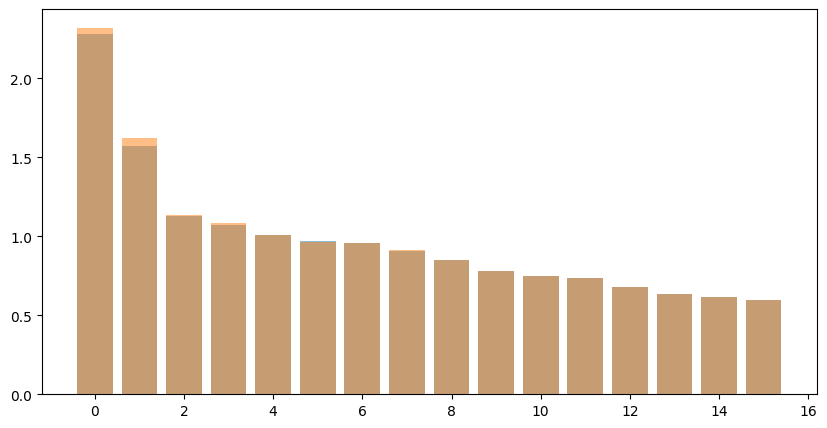

In [96]:
#plot the S values
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(range(len(S_260)), S_260, label='Epoch 260', alpha=0.5)
ax.bar(range(len(S_270)), S_270, label='Epoch 270', alpha=0.5)